### **Compañía Google**

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Nadam, Ftrl
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Carga de datos
df=pd.read_csv("https://raw.githubusercontent.com/JersonGB22/DataScience_IBM_StockPredictionLSTM_Project/main/DataStorage/datasets_company_etl.csv")
df["Date"]=pd.to_datetime(df.Date)
df

,Date,Open,High,Low,Close,Adj Close,Volume,id_company
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791185,560518000,AAPL
1,2013-01-02,27.250000,27.730000,27.150000,27.620001,22.620338,52899300,MSFT
2,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,TSLA
3,2013-01-02,12.804000,12.905000,12.663000,12.865500,12.865500,65420000,AMZN
4,2013-01-02,17.918339,18.107130,17.846855,18.013729,18.013729,102033017,GOOG
...,...,...,...,...,...,...,...,...
27379,2023-09-18,298.190002,303.600006,297.799988,302.549988,302.549988,14234200,META
27380,2023-09-18,327.799988,330.399994,326.359985,329.059998,329.059998,16834200,MSFT
27381,2023-09-18,140.479996,141.750000,139.220001,139.979996,139.979996,42823500,AMZN
27382,2023-09-18,271.160004,271.440002,263.760010,265.279999,265.279999,101543300,TSLA


In [3]:
# Función unificada
def feature_creation(df, company, input_len, output_len):

  def variable_selection(df, company):
    df2=df.copy()
    df2=df2[df2.id_company==company]
    df2=df2.iloc[:, :5].reset_index(drop=True)
    return df2

  df1=variable_selection(df, company)

  def data_scaling(set_data):
    set_data2=set_data.copy()
    cols=set_data2.columns[1:]
    list_mms=[MinMaxScaler() for c in set_data2.columns]
    for i, c in enumerate(cols):
      set_data2[c]=list_mms[i].fit_transform(set_data2[[c]])
    return set_data2, list_mms[1]

  df2, mms = data_scaling(df1)

  def train_test_split(set_data):
    set_train=set_data[set_data.Date<="2021-12-31"]
    set_test=set_data[set_data.Date>"2021-12-31"]
    return set_train.iloc[:, 1:].values, set_test.iloc[:, 1:].values

  set_train, set_test = train_test_split(df2)

  def find_xy(array, input_len, output_len):
    row, col = array.shape[0], array.shape[1]
    x, y = [], []
    for i in range(row-input_len-output_len+1):
      x.append(array[i:i+input_len])
      y.append(array[i+input_len:i+input_len+output_len, 1].reshape(output_len, 1))
    x=np.array(x)
    y=np.array(y)
    return x, y

  x_train, y_train = find_xy(set_train, input_len, output_len)
  x_test, y_test = find_xy(set_test, input_len, output_len)

  return x_train, y_train, x_test, y_test, mms

**OBSERVACIÓN:** En nuestro modelo de series de tiempo ``multivariado multi-step`` utilizando redes LSTM, hemos seleccionado bloques consecutivos de 90 días para el tamaño de entrada, para permitir una memoria más extensa en comparación con bloques de 30 días. También se evaluó con bloques de 60 días, pero se observó un aumento en la función de pérdida ``loss``. Además, he configurado el tamaño de salida en 7 días para que el modelo pueda realizar predicciones de las acciones máximas para una semana completa.

In [4]:
# Hallando los sets de entrenamiento y validación
input_len=90
output_len=7
x_train, y_train, x_test, y_test, mms = feature_creation(df, "GOOG", input_len, output_len)

#### **Creación, Compilación y Entrenamiento del modelo**
- Entradas: arreglos *x* (batches x input-length  x features = batches x 90 x 4)

- Salidas: arreglos *y* (batches x output-length x features = batches x 7 x 1)

- El modelo se compone de una capa LSTM con 256 unidades. Se realizaron experimentos con la cantidad de capas LSTM y el número de unidades, pero se observó un aumento en la función de pérdida. Además, se incorporó una capa Dropout para prevenir el overfitting con una tasa del 20%. La capa de salida utiliza una función de activación `linear`, que es la elección adecuada para problemas de series de tiempo, dado que otras funciones no son recomendables en este contexto.

- En la fase de compilación del modelo, se optó por emplear el optimizador ``Adam`` con un valor de ``learning_rate establecido`` en 0.001. Se realizaron pruebas con diversos optimizadores, incluyendo ``RMSprop`` y `SGD`, pero se observó un incremento en la función de pérdida. Asimismo, se llevaron a cabo experimentos con distintos valores de learning_rate para Adam, y se encontró que el que logró una reducción más significativa en el error fue el de 0.001. Como función de pérdida se seleccionó el RMSE (Root Mean Square Error):

    $RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

    donde:
- $y$: precio real más alto alcanzado durante el día por la compañía Google
- $\hat{y}$: precio predicho más alto alcanzado durante el día por la compañía Google
- $N$: cantidad de predicciones

- Durante el proceso de entrenamiento, se eligió un batch size de 256, y se determinó mediante experimentación que el número óptimo de épocas para lograr la reducción más efectiva de la función de error fue de 160.

In [5]:
# Ajuste de parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()
np.random.seed(123)

In [6]:
# Creación del modelo
model=Sequential()
model.add(LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(output_len, activation="linear"))

# Creación de la función de pérdida (Raíz del error cuadrático medio)
def RMSE(y_true, y_pred):
  rmse=tf.math.sqrt(tf.math.reduce_mean(tf.square(y_true-y_pred)))
  return rmse

# Creación del optimizador
optimizer=Adam(learning_rate=0.001)

# Compilación
model.compile(optimizer=optimizer, loss=RMSE)

# Entrenamiento
history=model.fit(x_train, y_train, batch_size=256, epochs=160, validation_data=(x_test, y_test), verbose=1)

Epoch 1/160
13/13 [==============================] - 8s 63ms/step - loss: 0.1398 - val_loss: 0.0658
Epoch 2/160
13/13 [==============================] - 0s 22ms/step - loss: 0.0447 - val_loss: 0.0456
Epoch 3/160
13/13 [==============================] - 0s 21ms/step - loss: 0.0353 - val_loss: 0.0375
Epoch 4/160
13/13 [==============================] - 0s 21ms/step - loss: 0.0330 - val_loss: 0.0392
Epoch 5/160
13/13 [==============================] - 0s 20ms/step - loss: 0.0318 - val_loss: 0.0374
Epoch 6/160
13/13 [==============================] - 0s 20ms/step - loss: 0.0308 - val_loss: 0.0336
Epoch 7/160
13/13 [==============================] - 0s 20ms/step - loss: 0.0293 - val_loss: 0.0385
Epoch 8/160
13/13 [==============================] - 0s 20ms/step - loss: 0.0283 - val_loss: 0.0374
Epoch 9/160
13/13 [==============================] - 0s 21ms/step - loss: 0.0280 - val_loss: 0.0356
Epoch 10/160
13/13 [==============================] - 0s 21ms/step - loss: 0.0274 - val_loss: 0.0343

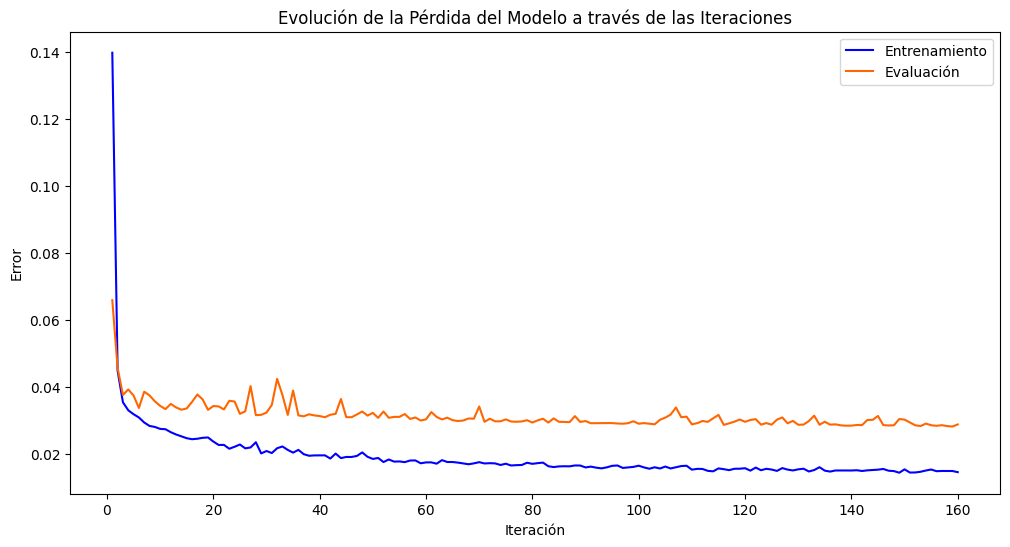

In [7]:
# Gráfica de la pérdida para verificar que no exista overfitting ni underfitting
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=np.arange(1, 161)

plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs, y=loss, color="blue", label="Entrenamiento")
sns.lineplot(x=epochs, y=val_loss, color="#FF6600", label="Evaluación")
plt.ylabel("Error")
plt.xlabel("Iteración")
plt.title("Evolución de la Pérdida del Modelo a través de las Iteraciones");

Del gráfico se visualiza que no se presenta overfitting, dado que a medida que la pérdida en el conjunto de entrenamiento disminuye, también lo hace en el conjunto de evaluación. Además, no se evidencia underfitting, ya que en cada iteración el valor de pérdida cada vez tiende más a 0 en ambos conjuntos, lo que indica un rendimiento excelente.

#### **Evaluación del Modelo**

In [8]:
rmse_train=model.evaluate(x=x_train, y=y_train, verbose=0)
rmse_test=model.evaluate(x=x_test, y=y_test, verbose=0)

print(f"RMSE train:\t {rmse_train}")
print(f"RMSE test:\t {rmse_test}")

RMSE train:	 0.00922820158302784
RMSE test:	 0.028029609471559525


**El rendimiento del modelo es excelente, ya que el RMSE del set de entrenamiento es de 0.009228 y del set de evaluación es de 0.02803, valores muy cercanos a 0.**

In [9]:
# Creación de una función para las predicciones
def predictions(x_test, model, mms):
  y_pred=model.predict(x_test, verbose=0)
  y_pred=mms.inverse_transform(y_pred)
  return y_pred.squeeze()

In [10]:
# Hallando las predicciones de los Highs máximos
y_pred=predictions(x_test, model, mms)

print(y_pred.shape)
print(y_pred)

(530, 7)
[[143.164   143.28416 143.04645 ... 143.77963 143.81342 144.03766]
 [142.38823 142.55087 142.29335 ... 143.05402 143.06845 143.28998]
 [143.61768 143.75235 143.49843 ... 144.22166 144.2392  144.43002]
 ...
 [138.83658 138.96027 138.72128 ... 139.45433 139.44153 139.64706]
 [139.09366 139.21768 138.97893 ... 139.7102  139.69882 139.90936]
 [139.18456 139.3144  139.07358 ... 139.80855 139.79704 140.0123 ]]


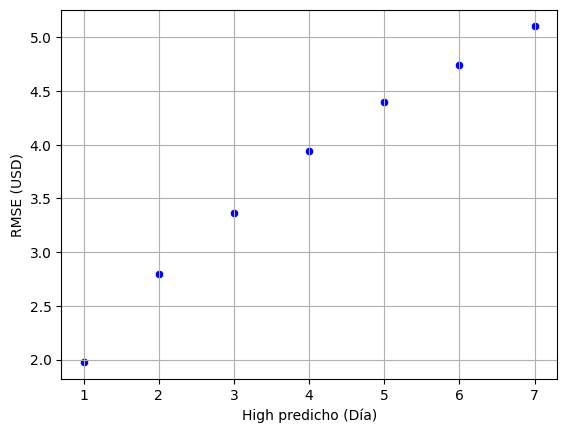

In [11]:
# Gráfica del RMSE en los 7 días predichos del set de testeo
y_test2=mms.inverse_transform(y_test.squeeze())
rmse=(((y_test2-y_pred)**2).mean(axis=0))**0.5
sns.scatterplot(x=np.linspace(1,7,7), y=rmse, color="blue")
plt.xlabel("High predicho (Día)")
plt.ylabel("RMSE (USD)")
plt.grid();

In [12]:
print("RMSE (USD) mínimo: ", round(rmse.min(),2))
print("RMSE (USD) máximo: ", round(rmse.max(),2))

RMSE (USD) mínimo:  1.97
RMSE (USD) máximo:  5.1


In [13]:
print("Promedio de RMSE (USD): ", mean_squared_error(y_test2, y_pred, squared=False))

Promedio de RMSE (USD):  3.7602197986445556


In [14]:
print("Promedio del Coeficiente de Determinación (R2): ", r2_score(y_test2, y_pred))

Promedio del Coeficiente de Determinación (R2):  0.9180602941808511


#### **CONCLUSIÓN:** A medida que se amplía el horizonte de predicción, se aprecia un incremento en el error. Utilizando la métrica RMSE, se observa que el error mínimo se registra en el día 1, alcanzando $1.97, mientras que el error máximo se presenta en el día 7, con un valor de $5.1. En términos generales, el RMSE promedio para los 7 días es de $3.76, con un coeficiente de determinación (R2) de 0.92, indicando un ajuste sólido del modelo a los datos. Esto significa que, en promedio, las predicciones del modelo se desvían en solo $3.76 de los valores reales de las acciones máximas de Google, respaldado por un R2 cercano al 100%, lo que refuerza la excelencia del modelo en su capacidad predictiva.

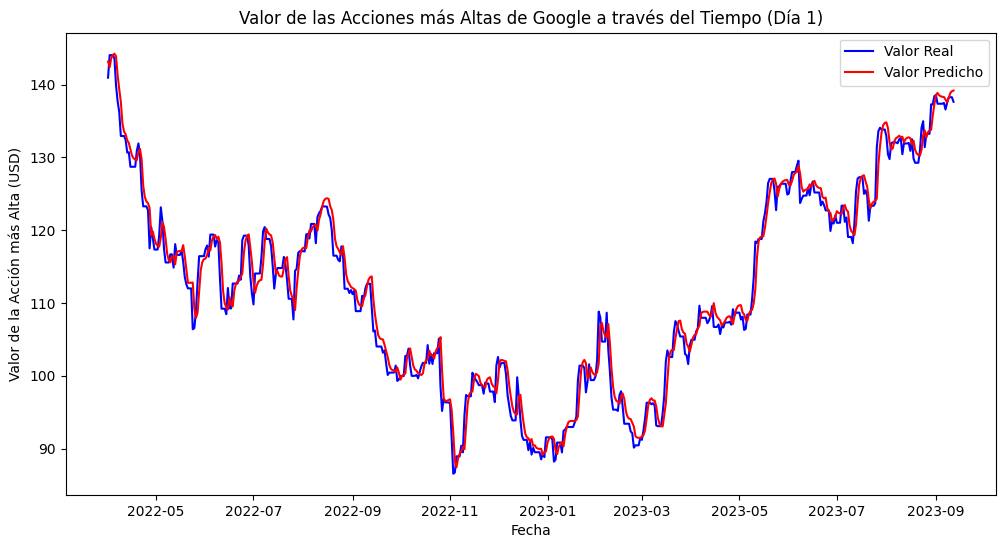

In [15]:
# Gráfica de las Acciones Reales y Predichas (Día 1)
df_google=df[df.id_company=="GOOG"].reset_index(drop=True)
day=1
start_index=df_google.shape[0]-y_test.shape[0]-output_len+day
end_index=-output_len+day # Si es el último día no se considera

plt.figure(figsize=(12,6))
sns.lineplot(x=df_google.iloc[start_index:end_index].Date, y=df_google.iloc[start_index:end_index].High, color="blue", label="Valor Real")
sns.lineplot(x=df_google.iloc[start_index:end_index].Date, y=y_pred[:, day-1], color="red", label="Valor Predicho")
plt.ylabel("Valor de la Acción más Alta (USD)")
plt.xlabel("Fecha")
plt.title(f"Valor de las Acciones más Altas de Google a través del Tiempo (Día {day})");

**Las predicciones son casi perfectas a simple vista, pues según el gráfico del RMSE solo difieren en promedio 1.97 USD**

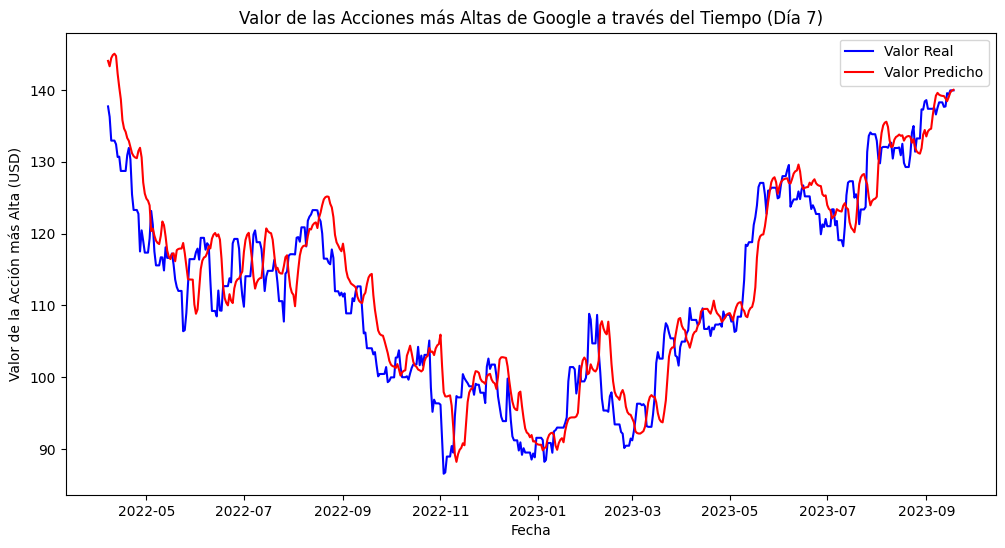

In [16]:
# Gráfica de las Acciones Reales y Predichas (Día 7)
df_google=df[df.id_company=="GOOG"].reset_index(drop=True)
day=7
start_index=df_google.shape[0]-y_test.shape[0]-output_len+day

plt.figure(figsize=(12,6))
sns.lineplot(x=df_google.iloc[start_index:].Date, y=df_google.iloc[start_index:].High, color="blue", label="Valor Real")
sns.lineplot(x=df_google.iloc[start_index:].Date, y=y_pred[:, day-1], color="red", label="Valor Predicho")
plt.ylabel("Valor de la Acción más Alta (USD)")
plt.xlabel("Fecha")
plt.title(f"Valor de las Acciones más Altas de Google a través del Tiempo (Día {day})");

**Las predicciones difieren un poco más, pues según el gráfico del RMSE difieren en promedio en 5.1 USD**

#### **Guardando el modelo entrenado en un archivo en formato nativo de Keras**

In [17]:
model.save("model_google.keras")